In [1]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import problem
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import geopy.distance

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv(
    os.path.join('data', 'train.csv.bz2')
)
data.loc[:, 'DateOfDeparture'] = pd.to_datetime(data.loc[:, 'DateOfDeparture'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateOfDeparture   8902 non-null   datetime64[ns]
 1   Departure         8902 non-null   object        
 2   Arrival           8902 non-null   object        
 3   WeeksToDeparture  8902 non-null   float64       
 4   log_PAX           8902 non-null   float64       
 5   std_wtd           8902 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 417.4+ KB


In [4]:
X, y = problem.get_train_data()
X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])

In [5]:
class MergeTransformer():
    """Custom scaling transformer"""
    
    def read_csv_ramp(self, parse_dates=["Date"]):
        self.filepath = os.path.join(
            self.filepath, self.filename
        )
        
        data = pd.read_csv(os.path.join('data', 'train.csv.bz2'))
        if parse_dates is not None:
            ext_data = pd.read_csv(self.filepath, parse_dates=parse_dates)
        else:
            ext_data = pd.read_csv(self.filepath)
        return ext_data
    
    def merge_external_data(self):

        X = self.X.copy()  # to avoid raising SettingOnCopyWarning
        # Make sure that DateOfDeparture is of dtype datetime
#         X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])

        if not(self.filename is None):
            self.X_ext = self.read_csv_ramp(parse_dates=self.parse_dates)

        if self.cols_to_keep != 'all':
            self.X_ext = self.X_ext[self.cols_to_keep]

        if self.cols_to_rename != None:
            self.X_ext = self.X_ext.rename(columns=self.cols_to_rename)

        X_merged = pd.merge(
            X, self.X_ext, how=self.how, on=self.on, sort=False
        )
        return X_merged

    
    def __init__(self, X_ext=None, filename=None, filepath='submissions/starting_kit/', cols_to_keep='all', cols_to_rename=None, how='left', on=None, parse_dates=None):
#         super().__init__(func)
        self.X_ext = X_ext
        self.filename = filename
        self.filepath = filepath
        self.cols_to_keep = cols_to_keep
        self.cols_to_rename = cols_to_rename
        self.how = how
        self.on = on
        self.parse_dates = parse_dates
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform()

    def fit(self, X):
        self.X = X

    def transform(self):
        return self.merge_external_data()

In [6]:
database_df = {}

### get date df

In [7]:
from sklearn.preprocessing import FunctionTransformer

def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    # Once we did the encoding, we will not need DateOfDeparture
#     return X_encoded.drop(columns=["DateOfDeparture"])
    return X_encoded

date_df = pd.DataFrame(X.loc[:, 'DateOfDeparture'])
date_encoder = FunctionTransformer(_encode_dates)
date_df = date_encoder.fit_transform(date_df)
date_df.sort_values('DateOfDeparture', inplace=True)
date_df.drop_duplicates('DateOfDeparture', inplace=True)
database_df['Date'] = date_df
database_df['Date'].head()

<ipython-input-7-1454f54b40d2>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


,DateOfDeparture,year,month,day,weekday,week,n_days
1544,2011-09-01,2011,9,1,3,35,15218
7904,2011-09-02,2011,9,2,4,35,15219
7215,2011-09-03,2011,9,3,5,35,15220
552,2011-09-04,2011,9,4,6,35,15221
1677,2011-09-05,2011,9,5,0,36,15222


In [8]:
__file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')
filepath

'submissions/starting_kit/external_data.csv'

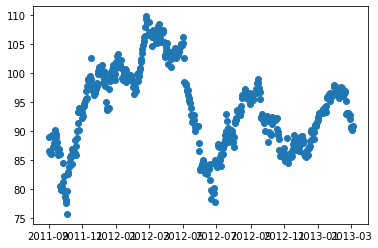

In [9]:
oil = pd.read_csv('data/oil_price.csv')
oil.loc[:, 'date'] = pd.to_datetime(oil.loc[:, 'date'], format='%d/%m/%Y')
oil.dropna(inplace=True)

merge_transform = MergeTransformer(
    X_ext=oil, 
    filename=None,
    filepath=None,
    cols_to_rename={'date': 'DateOfDeparture'},
    how='left',
    on=['DateOfDeparture'],
    parse_dates=None)

database_df['Date'] = merge_transform.fit_transform(database_df['Date'])
database_df['Date'].interpolate(method='linear', inplace=True)

database_df['Date'].isna().sum()

plt.scatter(database_df['Date'].loc[:, 'DateOfDeparture'], database_df['Date'].loc[:, 'value'])

### get weather df

In [10]:
weather_df = pd.read_csv('data/external_data.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.drop('Events', axis=1, inplace=True)
weather_df.drop('Max Gust SpeedKm/h', inplace=True, axis=1)
database_df['Weather'] = weather_df
database_df['Weather'].head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,0.00,3,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,0.00,2,185
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,0.00,4,147
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,6.10,6,139
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,16.00,8,149


### get airports

In [11]:
airport_df = pd.read_csv('data/list-of-airports-in-united-states-of-america-hxl-tags-1.csv')
airport_df.drop(0, axis=0, inplace=True)
print(airport_df.shape)
airport_df.drop_duplicates(['iata_code'], inplace=True)
print(airport_df.shape)
airport_df.loc[:, 'iso_region'] = airport_df.loc[:, 'iso_region'].str.strip('US-')
airport_df = airport_df.loc[:, ['ident', 'latitude_deg', 'longitude_deg', 'iso_region']]
airport_df.rename({'ident': 'iata', 'iso_region': 'state'}, axis=1, inplace=True)
airport_df['iata'] = airport_df['iata'].apply(lambda x: x[-3:])

airports_rank = pd.read_csv('data/airports_passengers.csv', sep=';', encoding = "utf-8")

merge_transform = MergeTransformer(
    X_ext=airports_rank, 
    filename=None,
    filepath=None,
    cols_to_keep=['2016', 'IATA'], 
    cols_to_rename={'IATA': 'iata', '2016': 'capacity'},
    how='left',
    on=['iata'],
    parse_dates=None)

airport_df = merge_transform.fit_transform(airport_df)
print(airport_df.shape)
database_df['Airport'] = airport_df
database_df['Airport'].head()

airport_df.drop_duplicates(['iata'], inplace=True)
print(airport_df.shape)

database_df['Airport'].to_csv('data/shit.csv')

(22216, 20)
(1983, 20)
(1983, 5)
(1944, 5)


In [12]:
print(database_df['Date'].head())

  DateOfDeparture  year  month  day  weekday  week  n_days    value
0      2011-09-01  2011      9    1        3    35   15218  88.9300
1      2011-09-02  2011      9    2        4    35   15219  86.4500
2      2011-09-03  2011      9    3        5    35   15220  86.3425
3      2011-09-04  2011      9    4        6    35   15221  86.2350
4      2011-09-05  2011      9    5        0    36   15222  86.1275


### get feature state date

In [13]:
unemployement = pd.read_csv("data/unemployment_rate.csv", sep=';', index_col='State')

unemployement.stack()
unemployement = pd.DataFrame(unemployement.stack()).reset_index(drop=False)
unemployement.rename(columns={"State": "State", "level_1": "DateOfDeparture", 0: "UnemployementRate"}, inplace=True)
unemployement.loc[:, 'DateOfDeparture'] = pd.to_datetime(unemployement.loc[:, 'DateOfDeparture'], format='%d/%m/%Y')

date_encoder = FunctionTransformer(_encode_dates)
unemployement = date_encoder.fit_transform(unemployement)

unemployement.rename(columns={"DateOfDeparture": "Date"}, inplace=True)

print(unemployement.shape)

merge_transform = MergeTransformer(
    X_ext=database_df['Date'],
    cols_to_keep=['DateOfDeparture', 'year', 'month'],
    how='right',
    on=['year', 'month'],
    parse_dates=None)

unemployement = merge_transform.fit_transform(unemployement)

print(unemployement.head())

states_codes = pd.read_csv("data/states.csv")

print(unemployement.shape)

merge_transform = MergeTransformer(
    X_ext=states_codes, 
    filename=None,
    filepath=None, 
    cols_to_rename={'State': 'State'},
    how='left',
    on=['State'],
    parse_dates=None)

unemployement = merge_transform.fit_transform(unemployement)

print(unemployement.shape)

unemployement['DateOfDeparture'] = pd.to_datetime(unemployement['DateOfDeparture'], format='%d/%m/%Y')
unemployement.drop('State', axis=1, inplace=True)
unemployement.rename({'Abbreviation': 'state'}, axis=1, inplace=True)
print(unemployement.shape)


<ipython-input-7-1454f54b40d2>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


(1872, 9)
        State       Date UnemployementRate  year  month  day  weekday  week  \
0     Alabama 2011-09-01               9.8  2011      9    1        3    35   
1      Alaska 2011-09-01               7.6  2011      9    1        3    35   
2     Arizona 2011-09-01               9.1  2011      9    1        3    35   
3    Arkansas 2011-09-01               8.3  2011      9    1        3    35   
4  California 2011-09-01              11.9  2011      9    1        3    35   

   n_days DateOfDeparture  
0   15218      2011-09-01  
1   15218      2011-09-01  
2   15218      2011-09-01  
3   15218      2011-09-01  
4   15218      2011-09-01  
(28704, 10)
(28704, 11)
(28704, 10)


In [14]:
import holidays

unemployement['bank_holidays'] = unemployement.apply(lambda x: x.Date in holidays.US(years = x.Date.year, state=x.state), axis=1)
unemployement.head()

school_holidays = pd.read_csv('data/holidays.csv', sep=';', parse_dates=['date'])

merge_transform = MergeTransformer(
    X_ext=school_holidays, 
    filename=None,
    filepath=None,
    cols_to_keep=['date', 'is_vacation'], 
    cols_to_rename={'date': 'Date', 'is_vacation': 'school_holidays'},
    how='left',
    on=['Date'],
    parse_dates=None)

unemployement = merge_transform.fit_transform(unemployement)
print(unemployement.shape)

(28704, 12)


In [15]:
unemployement.loc[:, 'holidays'] = unemployement.loc[:, 'bank_holidays'] | unemployement.loc[:, 'school_holidays']
unemployement.drop(['bank_holidays', 'school_holidays'], inplace=True, axis=1)
database_df['StateFeatures'] = unemployement
database_df['StateFeatures'].head()

database_df['StateFeatures'].to_csv('data/shit.csv')

In [16]:
database_df['StateFeatures'].head()

,Date,UnemployementRate,year,month,day,weekday,week,n_days,DateOfDeparture,state,holidays
0,2011-09-01,9.8,2011,9,1,3,35,15218,2011-09-01,AL,False
1,2011-09-01,7.6,2011,9,1,3,35,15218,2011-09-01,AK,False
2,2011-09-01,9.1,2011,9,1,3,35,15218,2011-09-01,AZ,False
3,2011-09-01,8.3,2011,9,1,3,35,15218,2011-09-01,AR,False
4,2011-09-01,11.9,2011,9,1,3,35,15218,2011-09-01,CA,False


# Merging

In [17]:
def merge_dfs(X, dict_features):
    
    merge_transform = MergeTransformer(X_ext=dict_features['Date'], how='left', on=['DateOfDeparture'])
    X = merge_transform.fit_transform(X)
        
    merge_transform = MergeTransformer(
        X_ext=dict_features['Airport'], 
        cols_to_rename={'iata': 'Departure',
                        'latitude_deg': 'latitude_departure',
                        'longitude_deg': 'longitude_departure',
                        'state': 'state_departure',
                        'capacity': 'capacity_departure'},
        how='inner', on=['Departure'])
    X = merge_transform.fit_transform(X)

    merge_transform = MergeTransformer(
        X_ext=dict_features['Airport'], 
        cols_to_rename={'iata': 'Arrival', 
                        'latitude_deg': 'latitude_arrival', 
                        'longitude_deg': 'longitude_arrival',
                        'state': 'state_arrival',
                        'capacity': 'capacity_arrival'},
        how='inner', on=['Arrival'])

    X = merge_transform.fit_transform(X)
    
    X['distance'] = X.apply(lambda x: geopy.distance.geodesic(
        (x.latitude_departure, x.longitude_departure), 
        (x.latitude_arrival, x.longitude_arrival)).km, axis=1)
    
    merge_transform = MergeTransformer(
        X_ext=dict_features['Weather'], 
        cols_to_rename={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'}, 
        how='left',
        on=['DateOfDeparture', 'Arrival'])

    X = merge_transform.fit_transform(X)

    merge_transform = MergeTransformer(
        X_ext=dict_features['StateFeatures'],
        cols_to_keep=['DateOfDeparture', 'state', 'UnemployementRate', 'holidays'],
        cols_to_rename={'state': 'state_departure'}, 
        how='left',
        on=['DateOfDeparture', 'state_departure'])

    X = merge_transform.fit_transform(X)
  
    return X

In [18]:
X_full = merge_dfs(X, database_df)
X_full.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days,value,latitude_departure,longitude_departure,state_departure,capacity_departure,latitude_arrival,longitude_arrival,state_arrival,capacity_arrival,distance,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,UnemployementRate,holidays
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,19,1,25,15510,84.222,41.97859955,-87.90480042,IL,37589899.0,32.89680099487305,-97.03800201416016,TX,31283579.0,1290.346797,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,0.00,5,161,8.7,False
1,2012-07-19,ORD,DFW,11.130435,7.027895,2012,7,19,3,29,15540,92.846,41.97859955,-87.90480042,IL,37589899.0,32.89680099487305,-97.03800201416016,TX,31283579.0,1290.346797,38,32,26,21,18,16,74,51,27,1018,1016,1013,16,16,16,24,15,0.00,1,208,8.9,False
2,2011-12-09,ORD,DFW,12.652174,9.527991,2011,12,9,4,49,15317,99.410,41.97859955,-87.90480042,IL,37589899.0,32.89680099487305,-97.03800201416016,TX,31283579.0,1290.346797,9,5,1,6,4,-2,100,85,70,1031,1025,1021,16,10,1,27,11,0.00,7,47,9.8,False
3,2012-03-26,ORD,DFW,11.263158,9.170254,2012,3,26,0,13,15425,107.030,41.97859955,-87.90480042,IL,37589899.0,32.89680099487305,-97.03800201416016,TX,31283579.0,1290.346797,28,21,14,15,13,12,80,62,43,1017,1015,1014,16,16,16,27,11,0.00,2,170,8.8,False
4,2012-10-17,ORD,DFW,10.136364,7.716991,2012,10,17,2,42,15630,92.214,41.97859955,-87.90480042,IL,37589899.0,32.89680099487305,-97.03800201416016,TX,31283579.0,1290.346797,31,23,16,18,13,5,84,55,26,1008,1003,1000,16,16,16,42,26,0.00,4,235,8.8,False


In [19]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'),
                    StandardScaler(with_mean=False),
                    LinearRegression())

print(X_full.shape)
print(y.shape)

(8902, 43)
(8902,)


In [20]:
pipe.fit(X_full, y)
X_full.isna().sum()

DateOfDeparture               0
Departure                     0
Arrival                       0
WeeksToDeparture              0
std_wtd                       0
year                          0
month                         0
day                           0
weekday                       0
week                          0
n_days                        0
value                         0
latitude_departure            0
longitude_departure           0
state_departure               0
capacity_departure            0
latitude_arrival              0
longitude_arrival             0
state_arrival                 0
capacity_arrival              0
distance                      0
Max TemperatureC              0
Mean TemperatureC             0
Min TemperatureC              0
Dew PointC                    0
MeanDew PointC                0
Min DewpointC                 0
Max Humidity                  0
Mean Humidity                 0
Min Humidity                  0
Max Sea Level PressurehPa     0
Mean Sea

In [29]:
y_pred = pipe.predict(X_full)
print(y_pred[:10])
print(y[:10])
print(pipe.score(X_full, y))

mean_error = np.sum(np.abs(y_pred - y)) / len(y)
print(mean_error)

[12.33129618 10.77518152 11.0831765  11.16926798 11.26936346 12.07364688
 11.17393575  9.5999523   9.1756453  10.73431945]
[12.33129622 10.77518151 11.08317675 11.16926784 11.26936373 12.07364919
 11.17393612  9.5999524   9.17564514 10.73431968]
0.9999999999994721
3.3418530832923904e-07


In [22]:
X_full.to_csv('data/X_full_features.csv')

# Testing

In [23]:
X_test, y_test = problem.get_test_data()
print(X_test.shape, y_test.shape)
X_test.head()

(2226, 5) (2226,)


,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-05-21,LAS,ORD,12.000000,9.860938
1,2012-12-20,SFO,DEN,10.600000,9.954634
2,2012-11-01,LGA,DTW,11.950000,9.207977
3,2012-01-03,DEN,LAS,11.476190,9.352107
4,2012-11-19,LAX,ATL,13.444444,10.363892


In [24]:
X_test.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_test.loc[:, 'DateOfDeparture'])
X_test_full = merge_dfs(X_test, database_df)
X_test_full.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days,value,latitude_departure,longitude_departure,state_departure,capacity_departure,latitude_arrival,longitude_arrival,state_arrival,capacity_arrival,distance,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,UnemployementRate,holidays
0,2012-05-21,LAS,ORD,12.000000,9.860938,2012,5,21,0,21,15481,92.7440,36.08010101,-115.1520004,NV,22833267.0,41.97859955,-87.90480042,IL,37589899.0,2436.933463,19,16,12,12,7,4,72,56,40,1022,1020,1017,16,16,16,40,20,0.00,5,5,11.6,False
1,2011-11-17,LAS,ORD,9.631579,6.601435,2011,11,17,3,46,15295,98.8860,36.08010101,-115.1520004,NV,22833267.0,41.97859955,-87.90480042,IL,37589899.0,2436.933463,2,-1,-4,-8,-10,-12,68,52,35,1024,1022,1020,16,16,16,39,17,0.00,1,253,"13,0",False
2,2012-09-08,LAS,ORD,15.407407,11.649560,2012,9,8,5,36,15591,96.4600,36.08010101,-115.1520004,NV,22833267.0,41.97859955,-87.90480042,IL,37589899.0,2436.933463,23,18,12,13,9,7,93,66,38,1013,1011,1010,16,16,11,29,19,7.11,2,306,11.8,False
3,2012-07-27,LAS,ORD,15.354839,11.382877,2012,7,27,4,30,15548,90.1300,36.08010101,-115.1520004,NV,22833267.0,41.97859955,-87.90480042,IL,37589899.0,2436.933463,30,24,19,19,18,16,90,67,44,1015,1010,1008,16,16,16,34,14,0.76,4,312,"12,0",False
4,2012-09-01,LAS,ORD,15.038462,11.714882,2012,9,1,5,35,15584,96.1775,36.08010101,-115.1520004,NV,22833267.0,41.97859955,-87.90480042,IL,37589899.0,2436.933463,24,23,22,21,19,16,87,76,64,1018,1016,1014,16,16,16,32,19,T,8,49,11.8,False


In [27]:
y_pred_test = pipe.predict(X_test_full)
print(y_pred_test[:10])
print(y_test[:10])
print(pipe.score(X_test_full, y_test))

mean_error = np.sum(np.abs(y_pred_test - y_test)) / len(y_test)
print(mean_error)

[11.16814139 11.12792995 11.54150432 11.84353642 10.50616984 11.61102749
 11.40432085 12.40207292 12.57554692 11.78584423]
[11.00826806 10.98261462 10.33432217 10.07586233 11.03357341 10.51539476
 10.93022421 11.25602654 10.79242331 10.54175528]
-1.879842080865826
1.353944109062386


# Happy ending

In [ ]:
def merge_dfs(database, submission_dir):
    
    X = database['Weather']
    
    merge_transform = MergeTransformer(X_ext=dict_features['Date'], how='left', on=['DateOfDeparture'])
    X = merge_transform.fit_transform(X)
        
    merge_transform = MergeTransformer(
        X_ext=dict_features['Airport'], 
        cols_to_rename={'iata': 'Departure',
                        'latitude_deg': 'latitude_departure',
                        'longitude_deg': 'longitude_departure',
                        'state': 'state_departure',
                        'capacity': 'capacity_departure'},
        how='inner', on=['Departure'])
    X = merge_transform.fit_transform(X)

#     merge_transform = MergeTransformer(
#         X_ext=dict_features['Airport'], 
#         cols_to_rename={'iata': 'Arrival', 
#                         'latitude_deg': 'latitude_arrival', 
#                         'longitude_deg': 'longitude_arrival',
#                         'state': 'state_arrival',
#                         'capacity': 'capacity_arrival'},
#         how='inner', on=['Arrival'])

#     X = merge_transform.fit_transform(X)
#     
#     X['distance'] = X.apply(lambda x: geopy.distance.geodesic(
#         (x.latitude_departure, x.longitude_departure), 
#         (x.latitude_arrival, x.longitude_arrival)).km, axis=1)
    
#     merge_transform = MergeTransformer(
#         X_ext=dict_features['Weather'], 
#         cols_to_rename={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'}, 
#         how='left',
#         on=['DateOfDeparture', 'Arrival'])

#     X = merge_transform.fit_transform(X)

    merge_transform = MergeTransformer(
        X_ext=dict_features['StateFeatures'],
        cols_to_keep=['DateOfDeparture', 'state', 'UnemployementRate', 'holidays'],
        cols_to_rename={'state': 'state_departure'}, 
        how='left',
        on=['DateOfDeparture', 'state_departure'])

    X = merge_transform.fit_transform(X)
    
    X.to_csv(submission_dir + '/external_data.csv')